<a href="https://colab.research.google.com/github/bimarshak7/learn_ml/blob/master/cardFraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.  
he dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The column V1 to v28 were obtained after PCA of higher dimension dataset. Original dataset wasn't provided due to Confidentiality. Amount and Time are same as in original dataset. 

In [305]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [306]:
#Set style and themes for visualization
%matplotlib inline
plt.style.use('seaborn-bright')
theme = plt.get_cmap('hsv')

In [307]:
#Load Dataset
df=pd.read_csv('/content/drive/MyDrive/creditcard.csv')
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
12478,21869.0,-0.816733,0.707937,2.527277,0.039711,0.069916,0.061994,0.321576,-0.003127,0.991796,-0.510886,2.401651,-2.714763,0.060669,1.732191,0.016519,0.067908,0.395881,0.463245,-0.384022,-0.118245,-0.053943,0.146481,-0.184699,0.149190,0.025851,0.307967,-0.287442,-0.186722,1.99,0
211994,138667.0,-8.924765,7.835131,-5.579684,-2.983668,-1.346246,-1.730463,0.028255,1.447091,5.312809,9.400369,0.968435,0.943798,-0.854515,-0.410133,-0.368763,-0.823469,-0.422444,-0.204304,-0.786014,3.609520,-0.544884,0.316425,0.369184,0.657247,1.221649,-0.005256,1.493417,0.667525,1.46,0
18177,29265.0,-0.891769,0.034708,2.315421,-1.788184,-0.631424,-0.759607,0.237696,-0.339222,-0.912165,0.266903,-0.413700,-1.102949,0.024097,-0.753883,0.486062,1.418886,-0.215962,-0.969748,-0.155527,0.108587,0.319849,0.866096,-0.394290,0.403582,0.421800,-0.241354,-0.403024,-0.096179,40.00,0
163112,115659.0,0.051700,0.625061,-1.691910,-1.525748,3.163825,3.182791,0.345568,0.922940,-0.159301,-0.805199,0.136686,-0.153691,-0.424451,-0.748270,0.158609,0.215677,0.352628,-0.369753,-0.401084,0.086674,-0.323438,-0.911175,0.148160,0.591469,-0.416600,0.163868,0.239462,0.073263,11.99,0
188073,127805.0,-0.186521,-0.284070,0.776131,-2.795429,-0.878994,0.204377,-1.565873,-2.676873,-2.270947,-0.008116,-1.184365,-0.825464,0.039457,-0.067388,-0.612378,-0.123229,0.403641,-0.196258,-1.130580,0.300620,-1.551524,-0.147063,-0.262268,0.639042,1.606125,-0.094843,-0.023639,0.158286,20.89,0


In [ ]:
#count numver of null or missing values
df.isna().sum().sum()

0

There are no null or missing value

In [ ]:
# df.shape,df.info()

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,1.772925e-15,9.289524e-16,-1.803266e-15,1.674888e-15,1.475621e-15,3.501098e-15,1.392460e-15,-7.466538e-16,4.258754e-16,9.019919e-16,5.126845e-16,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Data have different scales so it requires feature scaling. The amount and time column have very larger values in compared to other.

In [ ]:
n,y=df['Class'].value_counts()
print("There are only {} cases of fraud and {} cases of normal transaction among total of {} instances.".format(y,n,y+n))
print("Fraud: {:.3f}%\t Normal: {:.3f}%".format(y/(n+y) * 100,n/(n+y)*100))

There are only 492 cases of fraud and 284315 cases of normal transaction among total of 284807 instances.
Fraud: 0.173%	 Normal: 99.827%


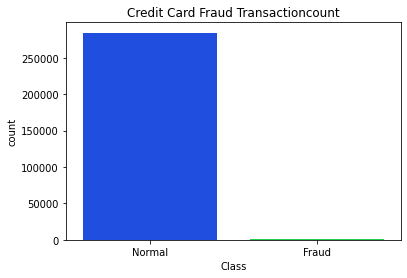

In [ ]:
sn.countplot(x="Class", data=df)
plt.title('Credit Card Fraud Transactioncount')
plt.xticks([0,1],['Normal',"Fraud"])
plt.show()

So, this is highly skewed data.

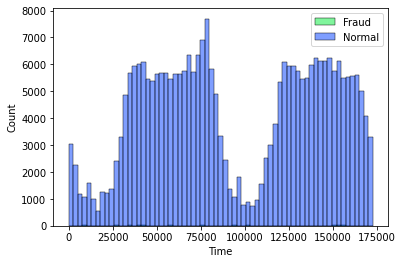

In [ ]:
fg=sn.histplot(df,x='Time',hue='Class')
plt.legend(['Fraud',"Normal"])
plt.show()

Fraud transaction can occur at any time

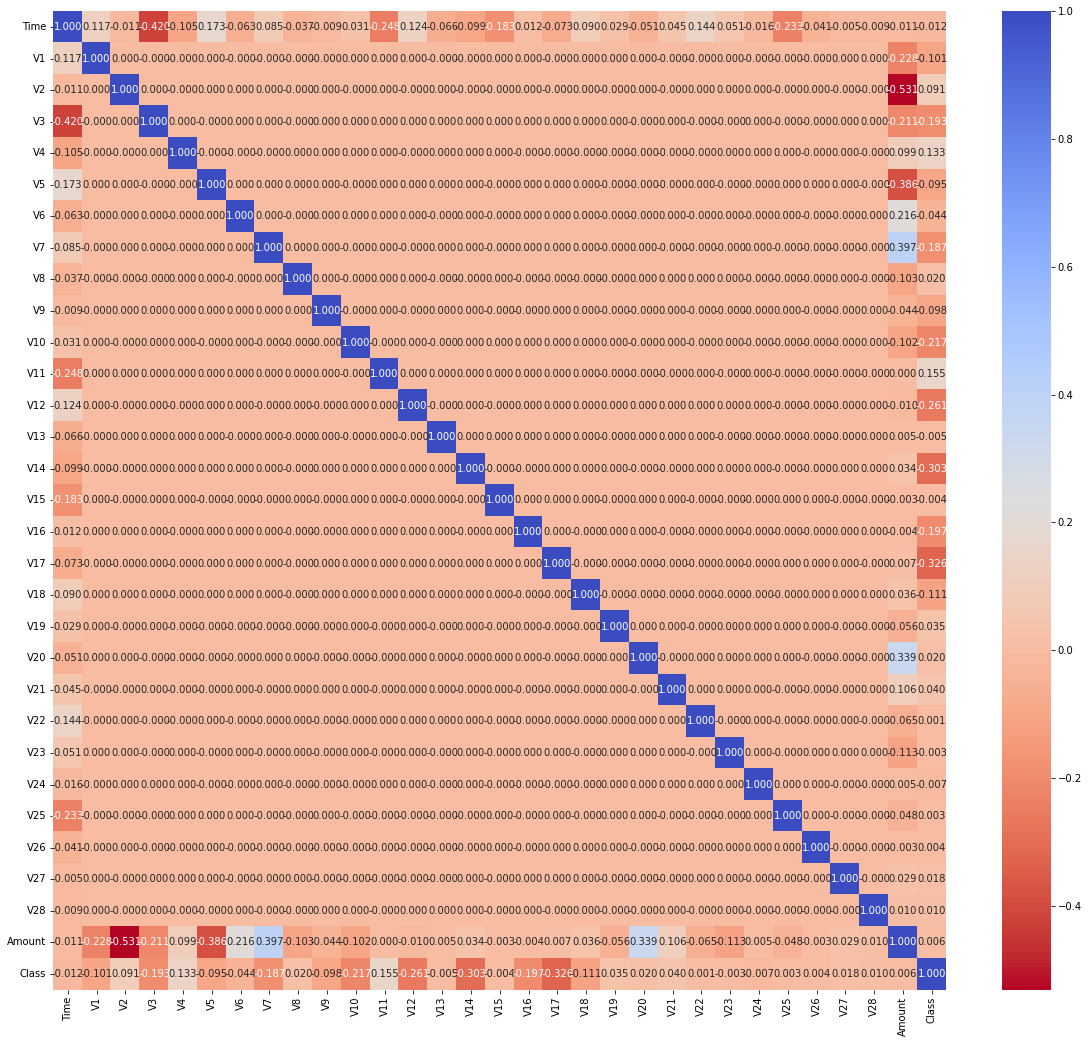

In [ ]:
fig, ax = plt.subplots(figsize=(20,18))
sn.heatmap(df.corr(),cmap='coolwarm_r',annot=True, fmt='.3f')
plt.show()

This correlation heat map shows that the correlation coefficient between time and Class is very low. It means fraud transaction can occur at any time of the day. Also, there is no specific range of amount for which the transaction can be abnormal one.
Among the values obtained after PCA, most have fair correlation coefficient with class. 

Sicne all the features are numerical, there is no necessity of encoding.

In [ ]:
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score

In [ ]:
#Split data into test and train set with same proportion of classed in both sets 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
for train_index, test_index in split.split(df, df["Class"]):
  train_set = df.loc[train_index]
  test_set = df.loc[test_index]

In [ ]:
#stratified sampling result
n,y=test_set['Class'].value_counts()
print("For Train set")
print("Fraud: {:.3f}%\t Normal: {:.3f}%".format(y/(n+y) * 100,n/(n+y)*100))

n,y=train_set['Class'].value_counts()
print("For Test set")
print("Fraud: {:.3f}%\t Normal: {:.3f}%".format(y/(n+y) * 100,n/(n+y)*100))

For Train set
Fraud: 0.172%	 Normal: 99.828%
For Test set
Fraud: 0.173%	 Normal: 99.827%


Now, the Time and Amount column needs to be scaled.

In [ ]:
#Scaling-> Standard, robust, minmax

In [ ]:
Y_train = train_set['Class']
Y_test = test_set['Class']
X_train = train_set.drop(['Class'],axis=1)
X_test = test_set.drop(['Class'],axis=1)

In [ ]:
def scale(train,test,method):
  model = method.fit(np.column_stack((train['Amount'].values,train['Time'].values)))
  tr= model.transform(np.column_stack((train['Amount'].values,train['Time'].values)))
  ts= model.transform(np.column_stack((test['Amount'].values,test['Time'].values)))
  train.drop(['Amount','Time'],axis=1,inplace=True)
  test.drop(['Amount','Time'],axis=1,inplace=True)
  return tr[:,0],tr[:,1],ts[:,0],ts[:,1]

X_train['SAmount'],X_train['STime'],X_test['SAmount'],X_test['STime'] = scale(X_train,X_test,StandardScaler())

# Model Selection and training

In [ ]:
def plotLearningCurves(X_train, y_train, classifier, title,cv=10):
    train_sizes, train_scores, test_scores = learning_curve(
            classifier, X_train, y_train, cv=cv, scoring="recall")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, label="Train Score")
    plt.plot(train_sizes, test_scores_mean, label="Test Score")
    
    plt.legend()
    plt.grid()
    plt.title(title, fontsize = 18, y = 1.03)
    plt.xlabel('Train Sizes', fontsize = 14)
    plt.ylabel('Score', fontsize = 14)
    plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score

In [ ]:
log_reg1=LogisticRegression(max_iter=500)
log_reg1.fit(X_train,Y_train)
pred_log1=log_reg1.predict(X_test)
print("For test set")
print('Confusion Matrix is\n',confusion_matrix(Y_test,pred_log1))
print('Recall is', recall_score(Y_test,pred_log1))
print('Precision score is', precision_score(Y_test,pred_log1))
print('F1 score is', f1_score(Y_test,pred_log1))
print('Accuracy is', accuracy_score(Y_test,pred_log1),"\n")

pred_log2=log_reg1.predict(X_train)
print("For train set")
print('Confusion Matrix is\n',confusion_matrix(Y_train,pred_log2))
print('Recall is', recall_score(Y_train,pred_log2))
print('Precision score is', precision_score(Y_train,pred_log2))
print('F1 score is', f1_score(Y_train,pred_log2))
print('Accuracy is', accuracy_score(Y_train,pred_log2))

For test set
Confusion Matrix is
 [[56851    13]
 [   34    64]]
Recall is 0.6530612244897959
Precision score is 0.8311688311688312
F1 score is 0.7314285714285713
Accuracy is 0.9991748885221726 

For train set
Confusion Matrix is
 [[227420     31]
 [   142    252]]
Recall is 0.6395939086294417
Precision score is 0.8904593639575972
F1 score is 0.7444608567208272
Accuracy is 0.9992407118874673


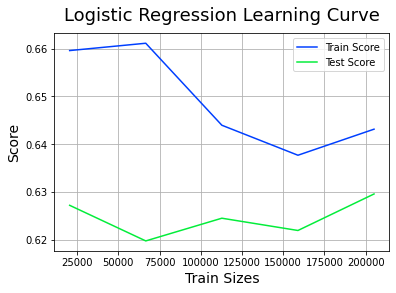

In [ ]:
plotLearningCurves(X_train,Y_train,log_reg1,'Logistic Regression Learning Curve')

In case of Credit card fraud, we can affrod to misclassify normal transcation as fraud one which can go for further evaluation rather than any fraud transaction classified as fair transaction.  
For this we want higher recall and can trade a little bit precision.

In [261]:
def Result(clf,X_train,X_test,Y_train, Y_test):
  clf.fit(X_train, Y_train)

  pred_test = clf.predict(X_test)
  pred_train= clf.predict(X_train)

  print("For test set")
  print('Confusion Matrix is\n',confusion_matrix(Y_test,pred_test))
  print('Recall is', recall_score(Y_test,pred_test))
  print('Precision score is', precision_score(Y_test,pred_test))
  print('F1 score is', f1_score(Y_test,pred_test))
  print('Accuracy is', accuracy_score(Y_test,pred_test),"\n")

  print("For train set")
  print('Confusion Matrix is\n',confusion_matrix(Y_train,pred_train))
  print('Recall is', recall_score(Y_train,pred_train))
  print('Precision score is', precision_score(Y_train,pred_train))
  print('F1 score is', f1_score(Y_train,pred_train))
  print('Accuracy is', accuracy_score(Y_train,pred_train))

  return pred_train, pred_test

In [ ]:
dtc=DecisionTreeClassifier()
Result(dtc, X_train, X_test,Y_train,Y_test)

For test set
Confusion Matrix is
 [[56850    14]
 [   27    71]]
Recall is 0.7244897959183674
Precision score is 0.8352941176470589
F1 score is 0.7759562841530054
Accuracy is 0.9992802219023208 

For train set
Confusion Matrix is
 [[227451      0]
 [     0    394]]
Recall is 1.0
Precision score is 1.0
F1 score is 1.0
Accuracy is 1.0


Cleary, decision tree with default hyperparameter didn't work well. It's overfitting. Lets search for best set of hyperparameter using gridsearch.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = [
 {'max_depth': [10,20,40], 'max_leaf_nodes':[70,20,60,80], 'max_features': [12, 15, 25, 30]},
]

grid_dtc = GridSearchCV(dtc, param_grid, cv=5,scoring='recall',return_train_score=True)
grid_dtc.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [10, 20, 40],
                          'max_features': [12, 15, 25, 30],
                          'max_leaf_nodes': [70, 20, 60, 80]}],
             return_train_score=True, scoring='recall')

In [ ]:
grid_dtc.best_estimator_

DecisionTreeClassifier(max_depth=40, max_features=15, max_leaf_nodes=70)

In [ ]:
dtc_best=grid_dtc.best_estimator_
Result(dtc_best, X_train, X_test,Y_train,Y_test)

For test set
Confusion Matrix is
 [[56856     8]
 [   25    73]]
Recall is 0.7448979591836735
Precision score is 0.9012345679012346
F1 score is 0.8156424581005587
Accuracy is 0.999420666409185 

For train set
Confusion Matrix is
 [[227451      0]
 [    53    341]]
Recall is 0.8654822335025381
Precision score is 1.0
F1 score is 0.927891156462585
Accuracy is 0.9997673857227501


The accuracy of the model is good. But the concern is over recall. Recall score isn't so good. Many fraud transactions are being classified as normal one. SO, let's try with RadomForest Classifier.

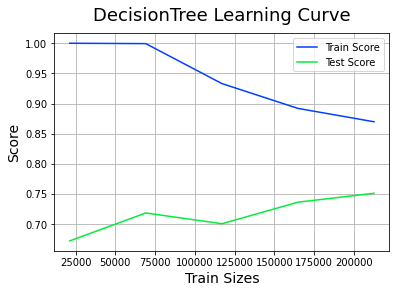

In [ ]:
plotLearningCurves(X_train,Y_train,dtc_best,'DecisionTree Learning Curve',cv=15)

Can improve more

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators=40, max_depth=40,max_leaf_nodes=4100)

Result(rfc, X_train, X_test,Y_train,Y_test)

For test set
Confusion Matrix is
 [[56860     4]
 [   20    78]]
Recall is 0.7959183673469388
Precision score is 0.9512195121951219
F1 score is 0.8666666666666666
Accuracy is 0.9995786664794073 

For train set
Confusion Matrix is
 [[227451      0]
 [     5    389]]
Recall is 0.9873096446700508
Precision score is 1.0
F1 score is 0.9936143039591315
Accuracy is 0.9999780552568632


Recall score has improved alot. But still we can try with different set of hyperparameter using GridSearch.

In [ ]:
params_rf = [
{
    #'n_estimators': [20, 40, 50],
 'max_depth':[40,50,60],'max_leaf_nodes':[3000,4000,4500]},
# {'bootstrap': [False], 'n_estimators': [10,20,30,40], 'max_features': [20,25,30]},
]
rfc = RandomForestClassifier()

In [ ]:
grid_search = GridSearchCV(rfc, params, cv=5,scoring='recall',return_train_score=True,n_jobs=-1)
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_depth': [40, 50, 60],
                          'max_leaf_nodes': [3000, 4000, 4500]}],
             return_train_score=True, scoring='recall')

In [ ]:
res = grid_search.cv_results_
for mean_score, params in zip(res["mean_test_score"], res["params"]):
  print(mean_score, params)

0.7613112625770853 {'max_depth': 40, 'max_leaf_nodes': 3000}
0.7536838688737423 {'max_depth': 40, 'max_leaf_nodes': 4000}
0.761278805582603 {'max_depth': 40, 'max_leaf_nodes': 4500}
0.7562155144433625 {'max_depth': 50, 'max_leaf_nodes': 3000}
0.7587471600129827 {'max_depth': 50, 'max_leaf_nodes': 4000}
0.7587471600129827 {'max_depth': 50, 'max_leaf_nodes': 4500}
0.7588120740019474 {'max_depth': 60, 'max_leaf_nodes': 3000}
0.7638104511522233 {'max_depth': 60, 'max_leaf_nodes': 4000}
0.7663745537163259 {'max_depth': 60, 'max_leaf_nodes': 4500}


In [ ]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=60, max_leaf_nodes=4500)

In [ ]:
rfc_best =RandomForestClassifier(max_depth=60, max_leaf_nodes=4500, n_estimators=25)
Result(rfc_best, X_train, X_test,Y_train,Y_test)

For test set
Confusion Matrix is
 [[56863     1]
 [   20    78]]
Recall is 0.7959183673469388
Precision score is 0.9873417721518988
F1 score is 0.8813559322033897
Accuracy is 0.9996313331694814 

For train set
Confusion Matrix is
 [[227450      1]
 [     6    388]]
Recall is 0.9847715736040609
Precision score is 0.9974293059125964
F1 score is 0.991060025542784
Accuracy is 0.9999692773596085


Let's try by removing columns which have less correlation coefficient.

In [ ]:
X_train1 = X_train.drop(['STime','SAmount'],axis=1)
X_test1 = X_test.drop(['STime','SAmount'],axis=1)

In [288]:
rfc_best1 =RandomForestClassifier(max_depth=20, max_leaf_nodes=4500, n_estimators=57)
predTr_ ,predTs= Result(rfc_best1, X_train1, X_test1,Y_train,Y_test)


For test set
Confusion Matrix is
 [[56862     2]
 [   19    79]]
Recall is 0.8061224489795918
Precision score is 0.9753086419753086
F1 score is 0.88268156424581
Accuracy is 0.9996313331694814 

For train set
Confusion Matrix is
 [[227451      0]
 [    18    376]]
Recall is 0.9543147208121827
Precision score is 1.0
F1 score is 0.9766233766233766
Accuracy is 0.9999209989247075


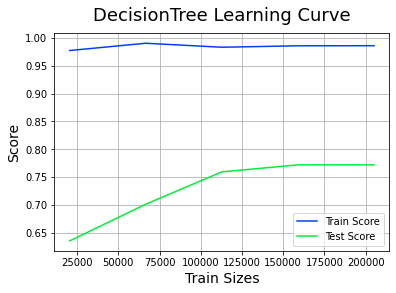

In [ ]:
plotLearningCurves(X_train,Y_train,rfc_best,'DecisionTree Learning Curve',cv=10)

In [ ]:
from sklearn.metrics import roc_curve

In [298]:
def plot_roc_curve(y_test,test_pred, y_train,train_pred,title='ROC Curve'):
  fpr1, tpr1, thresholds1 = roc_curve(y_test, test_pred)
  fpr2, tpr2, thresholds1 = roc_curve(y_train, train_pred)
  plt.plot(fpr2, tpr2, linewidth=2, label="Train")
  plt.plot(fpr1, tpr1, linewidth=2, label='Test',marker='+')
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title(title, fontsize = 18, y = 1.03)
  plt.xlabel('False Positive Rate', fontsize = 14)
  plt.ylabel('True Positive Rate', fontsize = 14)
  plt.legend()
  plt.show()

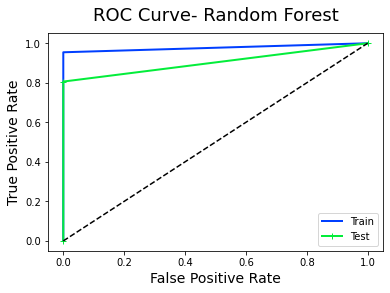

In [299]:
plot_roc_curve(Y_test,predTs,Y_train,predTr_ ,"ROC Curve- Random Forest")

## Under Sampling

This data contains 99% of negative classed instances. This cause effect in model performance to detect positive classes.So, we can try to train models by balancing that case. Here we will use undersampling(reduce no. of majority classs to the number same as minority class.)

In [229]:
number_records_fraud = len (df[df.Class==1])
fraud_indices = np.array (df[df.Class==1].index) # indices of all instances which are labelled as fraud
normal_indices = np.array (df[df.Class==0].index) # indices of all instances which are labelled as normal

random_normal_indices = np.random.choice (normal_indices, number_records_fraud, replace = False ) #randomly choose n(no. of fraud cases) instances from normal ones
under_sample_indices = np.concatenate ([fraud_indices, random_normal_indices])

under_sample_data = df.iloc[under_sample_indices,:] # create new dataset from undersampled data
X_undersample = under_sample_data.iloc [:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc [:, under_sample_data.columns == 'Class']

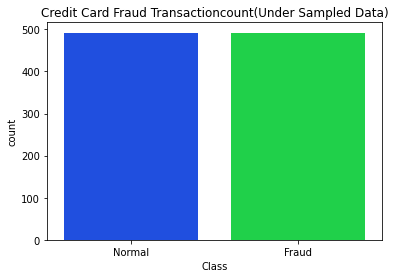

In [303]:
sn.countplot(x="Class", data=under_sample_data)
plt.title('Credit Card Fraud Transactioncount(Under Sampled Data)')
plt.xticks([0,1],['Normal',"Fraud"])
plt.show()

In [279]:
#split under sampled data into train and test set
from sklearn.model_selection import train_test_split
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split (X_undersample,y_undersample, test_size = 0.2, random_state = 21)
y_train_under = y_train_under.values.ravel()
y_test_under = y_test_under.values.ravel()


In [304]:
#perform scaling in amount and time column
X_train_under['SAmount'],X_train_under['STime'],X_test_under['SAmount'],X_test_under['STime'] = scale(X_train_under,X_test_under,StandardScaler())

In [236]:
#Grid Search for under sampled data to find best set of hyperparameter for random forest classifier
params_uG = [
{'n_estimators': [50,60,55,70],'max_depth':[10,25,40,57],'max_leaf_nodes':[3000,41000,4500],'max_features': [20,25,28,30],'min_samples_split':[2,4,6]},
]

rfc_uG = RandomForestClassifier()

grid_uG = GridSearchCV(rfc_uG, params_uG, cv=10,scoring='recall',return_train_score=True,n_jobs=-1)
grid_uG.fit(X_train_under, y_train_under)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'max_depth': [10, 25, 40, 57],
                          'max_features': [20, 25, 28, 30],
                          'max_leaf_nodes': [3000, 41000, 4500],
                          'min_samples_split': [2, 4, 6],
                          'n_estimators': [50, 60, 55, 70]}],
             return_train_score=True, scoring='recall')

In [242]:
grid_uB=grid_uG.best_estimator_
grid_uB

RandomForestClassifier(max_depth=10, max_features=25, max_leaf_nodes=4500,
                       n_estimators=50)

In [ ]:
res = grid_uG.cv_results_
for mean_score, params in zip(res["mean_test_score"], res["params"]):
  print(mean_score, params)

In [284]:
#Train and predict using best RF classifier
best_rfcl = RandomForestClassifier(max_depth=10, max_features=28, max_leaf_nodes=4100,min_samples_split=2, n_estimators=55)
pred_train,pred_test=Result(best_rfcl, X_train_under, X_test_under,y_train_under,y_test_under)

For test set
Confusion Matrix is
 [[103   1]
 [  9  84]]
Recall is 0.9032258064516129
Precision score is 0.9882352941176471
F1 score is 0.943820224719101
Accuracy is 0.949238578680203 

For train set
Confusion Matrix is
 [[388   0]
 [  1 398]]
Recall is 0.9974937343358395
Precision score is 1.0
F1 score is 0.9987452948557088
Accuracy is 0.9987293519695044


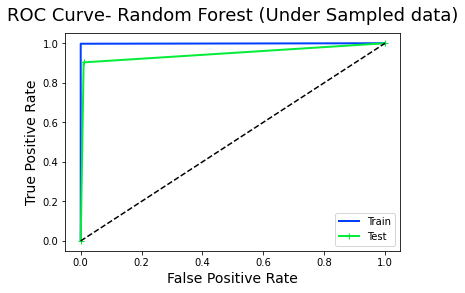

In [300]:
plot_roc_curve(y_test_under,pred_test,y_train_under,pred_train ,"ROC Curve- Random Forest (Under Sampled data)")

For the test set we achieved recall of 90.32% which is preety good. Recall might increase with the use of Neural Networks or other complex algorithms.